# CS242: Assignment 3





> Harvard CS 242: Computing at Scale (Fall 2022)

> 
> Instructor: Professor HT Kung


### **Assignment Instructions**

**Please start this assignment early, especially those who are interested in doing a final project involving Federated Learning.**

Read the following instructions carefully before starting the assignment and again before submitting your work:

* This programming assignment must be completed with the same group you worked with in Assignments 1 & 2. **If you have any issues with this arrangement, please email Andrew immediately.**
* We expect this assignment to take more time than Assignment 2. There is a more significant programming element involved, and more training time is required for the models. **Again, we suggest you start right away.**
* The assignment consists of two parts: **this Google Colab file** (an .ipynb file) and a **LaTeX answer template**.
* The Google Colab contains all assignment instructions and *Code Cells* that you will use to implement the programming components of the assignment in Python. **(Note: if there are any wording differences between the LaTeX template and this Colab file, the Colab file is authoritative and takes precedence.)**
* We provide a significant amount of the code to make it easier to get started. In the *Code Cells*, please add comments to explain the purpose of each line of code in your implementation. **You will not receive credit for implementations that are not well-documented.**
* <font color='red'>**Deliverables are highlighted in red**</font> in this Google Colab file. Use the LaTeX answer template to write down answers for these deliverables.
* Each group will submit both a PDF of your answers and your Google Colab file (.ipynb file) containing all completed *Code cells* to "Programming Assignment 3" on Canvas. Only one submission per group. Check your .ipynb file using this [tool](https://htmtopdf.herokuapp.com/ipynbviewer/) before submitting to ensure that you completed all *Code Cells* (including detailed comments).
* The assignment is due on **Wednesday, October 26, 2022 at 11:59 PM EST**.
* Each part you are asked to implement is relatively small in isolation, and should be easy to test. We strongly recommend you test each of these parts before training the large models as to not waste time training models with buggy implementions. For example, you should ensure that your sampling is being done correctly, otherwise the model will still train, but your results will not be correct. For a number of sections, we have provided checks you can run to ensure correctness prior to training a large model.

-----
An outline of this assignment with point values and training estimates is given below. Note that these estimates represent a lower bound on the running time, assuming a correct implementation.

1. **Exploring Federated Learning (FL)** [25 points] [Training Estimate: 2 hours]

2. **Non-IID Federated Learning and Fairness** [30 points] [Training Estimate: 3 hours]

3. **Quantization of Local Models for Reduced Communication Cost** [25 points] [Training Estimate: 3 hours]

4. **Backdoor Attacks by Malicious Clients and Defenses** [15 points] [Training Estimate: 1.5 hours]


---

### **1. Exploring Federated Learning (FL)**

---
We will be using a dataset (CIFAR-10) and CNN model (`ConvNet`) introduced in Programming Assignment 1. *Code Cell 1.1* creates the CIFAR-10 training and testing datasets. Additionally, it also contains the CNN (`ConvNet`)  that will be used throughout the assignment.

In [2]:
## Code Cell 1.1

import time
import copy
import sys
from collections import OrderedDict

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


# Using CIFAR-10 again as in Assignment 1
# Load training data
transform_train = transforms.Compose([                                   
    transforms.RandomCrop(32, padding=4),                                       
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True,
                                        transform=transform_train)

# Load testing data
transform_test = transforms.Compose([                                           
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)





Files already downloaded and verified
Files already downloaded and verified


In [3]:
mps = torch.device("mps")

In [4]:
# Saving And helpers
import matplotlib.ticker as ticker

def save_tracker(tracker, path):
  np.savetxt(path, tracker, delimiter=',') 

def save_trackers(device, filename):
  """Save all trackers and current total_time to a file."""
  torch.save((device['train_loss_tracker'], device['train_acc_tracker'], device['test_loss_tracker'], device['test_acc_tracker'], total_time), filename)
  print("Saved trackers to " + filename)

def moving_average(a, n=100):
  '''Helper function used for visualization'''
  ret = torch.cumsum(torch.Tensor(a), 0)
  ret[n:] = ret[n:] - ret[:-n]
  return ret[n - 1:] / n

# Plotting helpers! 
def make_plot(trackers, num_epochs, title, y_axis_lab, should_average=False, legend=True, fix_ax=True):
  avg_fn = moving_average if should_average else (lambda x : x) 
  x = np.arange(1, len(avg_fn(list(trackers.values())[0])) + 1)
  x = x / (len(x)/num_epochs)
  ax = plt.subplot(1,1,1)
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel(y_axis_lab)
  if fix_ax:
    ax.set_ylim([0, 100])
  # plt.xticks(np.arange(min(x), max(x)+1, 1))
  ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0f'))

  for lab, t in trackers.items(): 
    l1, = ax.plot(x, avg_fn(t), label = lab)

  if legend:
    _ = plt.legend()
  plt.show()

def make_plot_better(trackers, num_epochs, title, y_axis_lab, should_average=False, n = 100):
  avg_fn = (lambda x : moving_average(x, n)) if should_average else (lambda x : x) 
  x = np.arange(1, len(avg_fn(list(trackers.values())[0])) + 1)
  x = x / (len(x)/num_epochs)
  ax = plt.subplot(1,1,1)
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel(y_axis_lab)
  # plt.xticks(np.arange(min(x), max(x)+1, 1))
  ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0f'))

  for lab, t in trackers.items(): 
    l1, = ax.plot(x, avg_fn(t), label = lab)
  _ = plt.legend()
  plt.show()

**Federated Learning Overview**

Federated Learning (FL) distributes the task of training a deep neural network (such as our CNN `ConvNet`) across multiple client devices. Each client may have private data they do not want to share with a central server. Therefore, instead of transmitting data, clients perform training locally and send the updated model parameters (e.g., convolutional weights) to the server. The server averages these parameters across multiple clients to update the centralized model. Finally, after the centralized model has been updated, the server sends the new version of the model to all clients.

The figure below depicts this Federated Learning paradigm (taken from [Towards Federated Learning at Scale: System Design](https://arxiv.org/pdf/1902.01046.pdf)). At the beginning of a training round in the selection phase, a percentage of devices (i.e., clients) agree to participate. By agreeing to participate, a client agrees to perform local training with its own dataset that resides on the device. During the configuration phase, the up-to-date centralized model is sent to the participating clients, which then perform local training. In the reporting phase, each client sends their own updated model (trained using local data) to the server for aggregation. Note that, in the figure, one of the clients fails to report back to the central server (either due to device or network failure). To simplify this assignment, we will assume this type of device/network failure is not possible. 

<figure>
<center>
<img src='https://drive.google.com/uc?id=1y8HAIxtNaZVLWetXHEzJ4UXWJ0yX_Jo0' />
</figure>


**Simulating Federated Learning**

In this assignment, we will simulate this distributed Federated Learning environment on a single machine (i.e., a Colab instance). Each `device` will own a subset (or partition) of the dataset (e.g., 10% of the CIFAR-10 training set) and use it to train a local version of the model. The main difference between this simulated environment and a real system is the lack of networking between devices.

You will use the `DatasetSplit` class in *Code Cell 1.2* to create subsets of the full training dataset. The `create_device` function creates a unique instance of `ConvNet`, an instance of the `DatasetSplit` dataloader, and an optimizer and scheduler for training. This function will be called multiple times (once per device) to create all the required device instances used for Federated Learning. The `train` and `test` functions are a modified version from Assignment 2 that take a device argument (the output from `create_device`. The batch size during training is set to 128 throughout the assignment. This is passed into the `create_device` function as a default parameter value (i.e., `batch_size=128`).

In [5]:
## Code Cell 1.2
import copy

class DatasetSplit(torch.utils.data.Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, torch.tensor(label)
  
def create_device(net, device_id, trainset, data_idxs, lr=0.1,
                  milestones=None, batch_size=128):
    if milestones == None:
        milestones = [25, 50, 75]

    device_net = copy.deepcopy(net)
    optimizer = torch.optim.SGD(device_net.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=milestones,
                                                     gamma=0.1)
    device_trainset = DatasetSplit(trainset, data_idxs)
    device_trainloader = torch.utils.data.DataLoader(device_trainset,
                                                     batch_size=batch_size,
                                                     shuffle=True)
    return {
        'net': device_net,
        'id': device_id,
        'dataloader': device_trainloader, 
        'optimizer': optimizer,
        'scheduler': scheduler,
        'train_loss_tracker': [],
        'train_acc_tracker': [],
        'test_loss_tracker': [],
        'test_acc_tracker': [],
        }
  
def train(epoch, device):
    net.train()
    device['net'].train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(device['dataloader']):
        inputs, targets = inputs.to(mps), targets.to(mps)
        device['optimizer'].zero_grad()
        outputs = device['net'](inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        device['optimizer'].step()
        train_loss += loss.item()
        device['train_loss_tracker'].append(loss.item())
        loss = train_loss / (batch_idx + 1)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        dev_id = device['id']
        sys.stdout.write(f'\r(Device {dev_id}/Epoch {epoch}) ' + 
                         f'Train Loss: {loss:.3f} | Train Acc: {acc:.3f}')
        sys.stdout.flush()
    device['train_acc_tracker'].append(acc)
    sys.stdout.flush()

def test(epoch, device):
    net.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(mps), targets.to(mps)
            outputs = device['net'](inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            device['test_loss_tracker'].append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()  
    acc = 100.*correct/total
    device['test_acc_tracker'].append(acc)

**Single Device Scenario**

Before implementing Federated Learning, we will train a model for a single client device using only local data without sending updates to a central server. By doing this, the device is only able to look at a small percentage of the CIFAR-10 training set (10% in this case), and should perform poorly.

---
<font color='red'>**PART 1.1:**</font> [5 points]

<font color='red'>**Deliverables**</font>
1. In *Code Cell 1.3*, implement the function `iid_sampler` to generate **IID** (independent and identically distributed) samples from the CIFAR-10 training set. We will use this function to generate training subsets for multiple devices in **PART 1.2**.
2. In *Code Cell 1.4*, create a single device using the function `create_device`. This device should have 10% of the CIFAR-10 training set, obtained using `iid_sampler`.
3. Train the model for 1000 epochs using the parameters specified in *Code Cell 1.4* (similar to Assignment 2). The number of epochs is 10x greater due to the single device having only 10% of the data. Plot the test accuracy (`device['test_acc_tracker']`) over the epochs and comment on the classification accuracy compared to using 100% of the dataset as in Assignment 2. (50 words maximum)
---

In [6]:
## Code Cell 1.3

import random # can I add this?

def iid_sampler(dataset, num_devices, data_pct):
    '''
    dataset: PyTorch Dataset (e.g., CIFAR-10 training set)
    num_devices: integer number of devices to create subsets for
    data_pct: percentalge of training samples to give each device
              e.g., 0.1 represents 10%

    return: a dictionary of the following format:
      {
        0: [3, 65, 2233, ..., 22] // device 0 sample indexes
        1: [0, 2, 4, ..., 583] // device 1 sample indexes
        ...
      }

    iid (independent and identically distributed) means that the indexes
    should be drawn independently in a uniformly random fashion.
    START added by Silvia
    '''
    # total number of samples in the dataset
    total_samples = len(dataset)
    sampled = {}
    number_samples = int((data_pct)*(total_samples)) # compute the number of samples from the percentage
    # do we care about rounding up or down? I don't think so, so I just put int
    for i in range(num_devices):
      sampled[i] = random.sample(range(total_samples), number_samples) # returns list of random numbers without repeats
      # is it OK if the different users get repeated samples? Unclear
    
    # Part 1.1: Implement!
    
    return sampled

Now, perform training using a single device on a subset of the training dataset using your `iid_sampler`:

In [28]:
## Code Cell 1.4

data_pct = 0.1
epochs = 1000 # Part 1.1: Change to 1000 epochs
num_devices = 1
device_pct = 0.1
net = ConvNet().to(mps)
criterion = nn.CrossEntropyLoss()
milestones = [250, 500, 750]

'''
 START added by Silvia
'''
# Part 1.1: Implement cifar_iid to generate data_idxs for create_device
data_idxs = iid_sampler(trainset, num_devices, data_pct)

# Part 1.1: Create the device TODO
device = create_device(net, 0, trainset, data_idxs[0]) 
# The params are: (net, device_id, trainset, data_idxs, lr=0.1, milestones=None, batch_size=128)

print('Training for {} epochs and milestones {}'.format(
      epochs, milestones))

# Part 1.1: Train the device model for 100 epochs and plot the result
# Standard Training Loop
start_time = time.time()
for epoch in range(epochs):
    train(epoch, device)
    # To speed up running time, only evaluate the test set every 10 epochs
    if epoch > 0 and epoch % 10 == 0:
        test(epoch, device)
    device['scheduler'].step()
 

total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

Training for 1000 epochs and milestones [250, 500, 750]
(Device 0/Epoch 10) Train Loss: 1.340 | Train Acc: 51.080 | Test Loss: 1.536 | Test Acc: 44.570
(Device 0/Epoch 11) Train Loss: 1.345 | Train Acc: 50.058

KeyboardInterrupt: 

In [ ]:
save_trackers(device, "trackers_1_1.pth")

In [7]:
loss = {}
acc = {}
loss['train_loss'],_,_, acc['test_acc'], _ = torch.load("trackers_1_1.pth")
make_plot(loss, 1000, "Single Device Training Loss", "Training Loss", True, False, False)
make_plot(acc, 1000, "Single Device Test Accuracy", "Test Accuracy", False, False, True)

FileNotFoundError: [Errno 2] No such file or directory: 'trackers_1_1.pth'

In [8]:
# # this is what we need to save
# print(device['test_loss_tracker'])
# print(device['test_acc_tracker'])

In [9]:
# plt.plot(device['test_acc_tracker'])

In [10]:
# make_plot(device['train_loss_tracker'], 100, "Loss vs. Epoch", "Training Loss", False)
# make_plot(device['test_acc_tracker'], 100, "Accuracy vs. Epoch", "Test Accuracy (%)", False)

**Implementing Components for Federated Learning**

In **PART 1.1**, you implemented `iid_sampler`, created a 10% subset of the CIFAR-10 training set, and used it to train a single client device model. Since the client only had a 10% subset of the full CIFAR-10 training set, it performed significantly worse than the same model trained on the entire training set.

Federated Learning aims to improve the performance of these client devices by averaging the updates from multiple clients over the course of training. This way, a centralized server is able to be updated using the training data stored on local devices without having access to the training data.
By using more client devices, you will be able to leverage the entire dataset.
In a way, this simulates traditional gradient descent, but with additional epochs performed on each client before averaging, where each epoch uses mini-batches of size 128.
An additional benefit of federated learning is that the centralized server does not require large compute resources, as most of the training computation is performed on local devices.
This makes the training computation "free" for the centralized server, as the clients pay the compute cost on their local devices.

---
<font color='red'>**PART 1.2:**</font> [10 points]

Before implementing Federated Learning, you must implement two functions which will be used during the training process.

The `average_weights` function takes in multiple device models, and computes the average for each model parameter across all models. This function will be called by the centralized server to aggregate the training performed by the end user devices. This averaging is done in 32-bit floating point (`float32`).

The `get_devices_for_round` function will be used to simulate the device rejection phase shown earlier in the figure in the **Federated Learning Overview** section. This function will select a percentage of devices to participate in each training round.

<font color='red'>**Deliverables**</font>
1. In *Code Cell 1.5*, implement `average_weights`. We have provided test code you can use to validate your implementation. This test code will also be useful for the full implementation of Federated Learning in **PART 1.3**.
2. In *Code Cell 1.5*, implement the `get_devices_for_round` function. Try multiple `device_pct` settings to ensure that it is working properly.
---

In [11]:
## Code Cell 1.5
import copy

def average_weights(devices):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights.
    '''
    # Part 1.2: Implement!
    # Hint: device['net'].state_dict() will return an OrderedDict of all
    #       tensors in the model. Return the average of each tensor using
    #       an OrderedDict so that you can update the global model using
    #       device['net'].load_state_dict(w_avg), where w_avg is the 
    #       averaged OrderedDict over all devices
    state_dicts = [device['net'].state_dict() for device in devices]
    
    # initialize w_avg to tensors from device 0
    w_avg = copy.deepcopy(state_dicts[0])
    for k in w_avg.keys():
      w_avg[k] = w_avg[k].type(torch.float32)

    # for each model param
    for k in w_avg.keys():
        # for each remaining device i, add tensor state_dicts[i][k] to w_avg[k]
        for i in range(1, len(devices)):
            w_avg[k] += (state_dicts[i][k].type(torch.float32))
        # compute average
        w_avg[k] /= float(len(devices))
    return w_avg


def get_devices_for_round(devices, device_pct):  
    # Part 1.2: Implement!
    return random.sample(devices, int(device_pct * len(devices)))
  
# Test code for average_weights
# Hint: This test may be useful for Part 1.3!
class TestNetwork(nn.Module):
    '''
    A simple 2 layer MLP used for testing your average_weights implementation.
    '''
    def __init__(self):
        super(TestNetwork, self).__init__()
        self.layer1 = nn.Linear(2, 2)
        self.layer2 = nn.Linear(2, 4)
    
    def forward(self, x):
        h = F.relu(self.layer1(x))
        return self.layer2(h)

data_pct = 0.05
num_devices = 2
net = TestNetwork()
data_idxs = iid_sampler(trainset, num_devices, data_pct)
devices = [create_device(net, i, trainset, data_idxs[i])
           for i in range(num_devices)]

# Fixed seeding to compare against precomputed correct_weight_averages below
torch.manual_seed(0)
devices[0]['net'].layer1.weight.data.normal_()
devices[0]['net'].layer1.bias.data.normal_()
devices[0]['net'].layer2.weight.data.normal_()
devices[0]['net'].layer2.bias.data.normal_()
devices[1]['net'].layer1.weight.data.normal_()
devices[1]['net'].layer1.bias.data.normal_()
devices[1]['net'].layer2.weight.data.normal_()
devices[1]['net'].layer2.bias.data.normal_()

# Precomputed correct averages
correct_weight_averages = OrderedDict(
    [('layer1.weight', torch.tensor([[ 0.3245, -0.9013], [-0.9042,  1.0125]])),
     ('layer1.bias', torch.tensor([-0.0724, -0.3119])),
     ('layer2.weight', torch.tensor([[0.2976,  1.0509], [-1.0048, -0.5972],
                                     [-0.3088, -0.2682], [-0.1690, -0.1060]])),
     ('layer2.bias', torch.tensor([-0.4396,  0.3327, -1.3925,  0.3160]))
    ])

# Computed weight averages
computed_weight_averages = average_weights(devices)

mismatch_found = False
for correct, computed in zip(correct_weight_averages.items(),
                             computed_weight_averages.items()):
    if not torch.allclose(correct[1], computed[1], atol=1e-2):
        mismatch_found = True
        print('Mismatch in tensor:', correct[0])

if not mismatch_found:
    print('Implementation output matches!')

Implementation output matches!


In [58]:
from collections import namedtuple

BackdoorResult = namedtuple("BackdoorResult", ["scheme_loss", "test_accuracy", "backdoor_success", "devices"])

# Using same ConvNet as in Assignment 1
def conv_block(in_channels, out_channels, kernel_size=3, stride=1,
               padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 32),
#             conv_block(32, 32),
            conv_block(32, 64, stride=2),
#             conv_block(64, 64),
#             conv_block(64, 64),
            conv_block(64, 128, stride=2),
#             conv_block(128, 128),
            conv_block(128, 256),
#             conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)

def create_device(net, device_id, trainset, data_idxs, lr=0.1,
                  milestones=None, batch_size=128):
    if milestones == None:
        milestones = [25, 50, 75]

    device_net = copy.deepcopy(net)
    optimizer = torch.optim.SGD(device_net.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=milestones,
                                                     gamma=0.1)
    device_trainset = DatasetSplit(trainset, data_idxs)
    device_trainloader = torch.utils.data.DataLoader(device_trainset,
                                                     batch_size=batch_size,
                                                     shuffle=True)
    return {
        'net': device_net,
        'id': device_id,
        'dataloader': device_trainloader, 
        'optimizer': optimizer,
        'scheduler': scheduler,
        'train_loss_tracker': [],
        'train_acc_tracker': [],
        'test_loss_tracker': [],
        'test_acc_tracker': [],
        }
  
def train(epoch, device, criterion):
    net.train()
    device['net'].train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(device['dataloader']):
        inputs, targets = inputs.to(mps), targets.to(mps)
        device['optimizer'].zero_grad()
        outputs = device['net'](inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        device['optimizer'].step()
        train_loss += loss.item()
        device['train_loss_tracker'].append(loss.item())
        loss = train_loss / (batch_idx + 1)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        dev_id = device['id']
        sys.stdout.write(f'\r(Device {dev_id}/Epoch {epoch}) ' + 
                         f'Train Loss: {loss:.3f} | Train Acc: {acc:.3f}')
        sys.stdout.flush()
    device['train_acc_tracker'].append(acc)
    sys.stdout.flush()

def test(epoch, device, criterion):
    net.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(mps), targets.to(mps)
            outputs = device['net'](inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            device['test_loss_tracker'].append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()  
    acc = 100.*correct/total
    device['test_acc_tracker'].append(acc)

def diff_aggregated_weights(strat, baseline):
    result = 0 
    
    for k in strat.keys():
        result += torch.linalg.norm(strat[k] - baseline[k])
    
    return result

def run_federated_test(aggregation_function = average_weights, 
                       rounds = 10, 
                       local_epochs = 4, 
                       num_devices = 50, 
                       device_pct = 0.1, 
                       data_pct = 0.1, 
                       net = ConvNet().to(mps), 
                       evil_round = None, 
                       attacker_strategy = None,
                       evil_device_id = None,
                       evaluate_attack = None):
    
    criterion = nn.CrossEntropyLoss()
    data_idxs = iid_sampler(trainset, num_devices, data_pct)

    # Part 1.3: Implement device creation here
    devices = [create_device(net, i, trainset, data_idxs[i]) for i in range(num_devices)] # Implement this!
    
    scheme_loss = []

    ## IID Federated Learning
    start_time = time.time()
    for round_num in range(rounds):
        # Part 1.3: Implement getting devices for each round here
        round_devices = get_devices_for_round(devices, device_pct)

        print('Round: ', round_num)
        # Train locally 
        for device in round_devices:
            for local_epoch in range(local_epochs):
                train(local_epoch, device, criterion)
        
        # One device becomes evil if required
        if (evil_round and round_num == evil_round):
            assert (evil_device_id is not None)
            assert (attacker_strategy is not None)
            
            attacker_strategy(devices[evil_device_id])
            
        
        # Weight averaging
        w_baseline = average_weights(round_devices)
        w_avg = aggregation_function(round_devices)
        # Track the difference between the two; should be 0 if straight average
        scheme_loss.append((float(diff_aggregated_weights(w_avg, w_baseline))))
        
        # Gradients         
        for device in devices:
            device['net'].load_state_dict(w_avg)
            device['optimizer'].zero_grad()
            device['optimizer'].step()
            device['scheduler'].step()

        # test accuracy after aggregation
        # device 0 is the unique device with all of the 
        # test accuracies and losses in its tracker
        test(round_num, devices[0], criterion)
        
        print(f"\nDiff: {scheme_loss[-1]}\n")

    
    total_time = time.time() - start_time
    print('Total training time: {} seconds'.format(total_time))

    # Pack up everything we care about and the devices for good measure
    return BackdoorResult(
        scheme_loss = scheme_loss, 
        test_accuracy = devices[0]["test_acc_tracker"], 
        backdoor_success = evaluate_attack() if evaluate_attack is not None else None, 
        devices = devices
    )



In [59]:
results = run_federated_test(local_epochs=1, num_devices = 10, rounds = 2)

Round:  0
(Device 5/Epoch 0) Train Loss: 2.033 | Train Acc: 23.660 | Test Loss: 2.232 | Test Acc: 21.250

Diff: 0.0

Round:  1
(Device 7/Epoch 0) Train Loss: 1.848 | Train Acc: 30.220 | Test Loss: 1.802 | Test Acc: 33.040

Diff: 0.0

Total training time: 11.778191089630127 seconds


BackdoorResult(scheme_loss=[0.0, 0.0], test_accuracy=[21.25, 33.04], backdoor_success=None, devices=[{'net': ConvNet(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-

**Federated Learning Training**

---
<font color='red'>**PART 1.3:**</font> [10 points]

We will now run the federated learning in the IID setting using the functions you previously wrote in this section.
The parameters are given to you in the code.
You will use 100 rounds of federated learning updates.
For each round, each device that participates in a given round will complete 4 epochs of local training.
10% of devices should participate in each round, selected by the `get_devices_for_round` function you wrote previously.
Note that we use static initialization for the models between all parts of the assignment.

<font color='red'>**Deliverables**</font>
1. In *Code Cell 1.6*, train a global model via federated learning.
Much of the code has been given to you, but you will need to fill in the parts using calls to the functions you wrote above.

2. Graph the accuracy of the global model over 100 rounds.
Discuss the accuracy difference between the global model trained here and the individual local model you trained in **PART 1.1**. (50 words maximum)

In [31]:
## Code Cell 1.6

# use these parameters
rounds = 10 # Part 1.3: Change to 100 epochs
local_epochs = 4
num_devices = 50
device_pct = 0.1
data_pct = 0.1
net = ConvNet().to(mps)

criterion = nn.CrossEntropyLoss()
data_idxs = iid_sampler(trainset, num_devices, data_pct)

# Part 1.3: Implement device creation here
devices = [create_device(net, i, trainset, data_idxs[i]) for i in range(num_devices)] # Implement this!


## IID Federated Learning
start_time = time.time()
for round_num in range(rounds):
    # Part 1.3: Implement getting devices for each round here
    round_devices = get_devices_for_round(devices, device_pct)

    print('Round: ', round_num)
    for device in round_devices:
        for local_epoch in range(local_epochs):
            train(local_epoch, device)

    # Weight averaging
    w_avg = average_weights(round_devices)

    for device in devices:
        device['net'].load_state_dict(w_avg)
        device['optimizer'].zero_grad()
        device['optimizer'].step()
        device['scheduler'].step()

    # test accuracy after aggregation
    test(round_num, devices[0])


total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

Round:  0
(Device 41/Epoch 3) Train Loss: 1.705 | Train Acc: 34.640 | Test Loss: 1.751 | Test Acc: 32.860
Round:  1
(Device 49/Epoch 0) Train Loss: 1.729 | Train Acc: 34.493

KeyboardInterrupt: 

In [ ]:
save_trackers(devices[0], "trackers_1_3.pth")

In [ ]:
trackers = {}
_,_,_, trackers['test_acc_tracker'], _ = torch.load("trackers_1_3.pth")

make_plot(trackers, 100, "Global Model Accuracy", "Test Accuracy", legend=False)

---

### **2. Non-IID Federated Learning and Fairness**

---
**Overview**

In **PART 1**, you implemented a Federated Learning pipeline that operated on IID data.
While this IID assumption may hold in some applications, it does not hold in many other settings.
For example, a group of similar users may have data that is fundamentally different from that of another group of users.
As a result, the aggregate data that federated learning operates on will be non-IID in nature.

In **PART 2** of the assignment, you will explore using Federated Learning in a non-IID setting.
In this part of the assignment, you will create groups of devices such that the inter-group data is non-IID and the intra-group data is IID.
To do this, you will reimplement many of the functions you implemented in **PART 1** for this non-IID setting.

For all experiments in this section, we assume there are three groups.
Each group is assigned a different subset of classes in the dataset (Group 0 is assigned data from classes 0-3, Group 1 from classes 4-6, and Group 2 from classes 7-9).
We also fix each group to contain 20 devices, although you will vary per-group participation rates in each round in **PART 2.4**.

---
**Non-IID Sampling**

<font color='red'>**PART 2.1:**</font> [10 points]

We will first start by implementing `noniid_group_sampler`, a new, non-IID group version of the `iid_sampler` you implemented in PART 1.  We will use this function to generate training subsets for multiple devices in PART 2.4.  

<font color='red'>**Deliverables**</font>
1. In *Code Cell 2.1*, implement the `noniid_group_sampler` function to generate **non-IID** samples from the CIFAR-10 training set.
As input, the function should take the dataset and number of training samples each device should be assigned.
As in `iid_sampler` you implemented previously, the function should return a `dict` where each key is a device ID number and each value is a `set` of the indices of training samples in the dataset assigned to that device.
You may want to have the function return other data as well, depending on how you implement functions in later parts of the assignment.
We have provided the mapping that indicates which classes are mapped to each group.
Within a given group, you should sample the data in an IID fashion.
---

In [ ]:
## Code Cell 2.1

# Returns a dictionary splitting the database into indexed buckets.
# The output is a dictionary where for each (index : [classes]) pair in 
# dict_group_classes, there is an entry (index : [datapoints for corresponding classes]). 
def get_separated_database(dataset, dict_group_classes):

  class_to_group = {  }

  for group, classes in dict_group_classes.items():
    for c in classes:
      class_to_group[c] = group

  dataset_sep = { i : [] for i in range(len(dict_group_classes.keys()))}

  for i, item in enumerate(dataset):
    target = class_to_group[item[1]]
    dataset_sep[target].append(i)
  
  return dataset_sep


# creates noniid TRAINING datasets for each group
def noniid_group_sampler(dataset, num_items_per_device):
  '''
    dataset: PyTorch Dataset (e.g., CIFAR-10 training set)
    num_devices: integer number of devices to create subsets for
    num_items_per_device: how many samples to assign to each device

    return: a dictionary of the following format:
      {
        0: [3, 65, 2233, ..., 22] // device 0 sample indexes
        1: [0, 2, 4, ..., 583] // device 1 sample indexes
        ...
      }

  '''
  # how many devices per non-iid group
  devices_per_group = [20, 20, 20]
  num_devices = sum(devices_per_group) 

  # label assignment per group
  dict_group_classes = {}
  dict_group_classes[0] = [0,1,2,3]
  dict_group_classes[1] = [4,5,6]
  dict_group_classes[2] = [7,8,9] 

  # what group does a device id belong to
  device_id_to_group = lambda id : int(id/20)
  
  # separate by group
  dataset_sep = get_separated_database(dataset, dict_group_classes) 
  
  # Perform sampling as desired
  return {
      i : 
      random.sample(dataset_sep[device_id_to_group(i)], num_items_per_device)
      for i in range(num_devices)
  }

In [ ]:
# Test the noniid_group_sampler
def test_non_iid_sampler(dataset):
  test = noniid_group_sampler(dataset, 5)
  for id, indices in test.items():
    for index in indices: 
      if id < 20:
        assert (trainset[index][1] in [0,1,2,3])
      elif id < 40:
        assert (trainset[index][1] in [4,5,6])
      else: 
        assert (trainset[index][1] in [7,8,9])
test_non_iid_sampler(trainset)

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True,
                                        transform=transform_train)

Files already downloaded and verified


---
**Group-based Device Rejection**

<font color='red'>**PART 2.2:**</font> [5 points]

We will now implement `get_devices_for_round_GROUP`, a new group-based version of the `get_devices_for_round` you implemented in **PART 1**.
We will use this function in **PART 2.4** to simulate the device rejection phase shown earlier on a per-group basis.  

<font color='red'>**Deliverables**</font>
1. In *Code Cell 2.2*, implement the `get_devices_for_round_GROUP` function to generate a list of devices that will participate in each round of federated learning.
The function should, at minimum, take as input 1) the list of all devices, and 2) how many devices from each group should participate in a given round.
It should return a list of devices that will participate in a given round.
You may want to add additional input parameters depending on your implementation strategy.

In [ ]:
## Code Cell 2.2

# get which devices in each group should participate in a current round
# by explicitly saying number of each devices desired for each group 

def get_devices_for_round_GROUP(devices, device_nums, user_group_idxs):
    devices_per_group = [20, 20, 20]
    base = 0
    results = []
    for idx, num in enumerate(devices_per_group): 
        results += random.sample(devices[base:base + num], device_nums[idx])
        base += num
    
    return results

---
**Group-based Testing**

<font color='red'>**PART 2.3:**</font> [5 points]

We will now implement the testing functions needed to evaluate the global model learned via Federated Learning on a per-group basis.  This will require two functions:



* `cifar_noniid_group_test` divides the test dataset into three subsets, one subset for each group. 
* `test_group` gets per-group classification accuracy for the global model.
You will likely want to start with the `test` function from **Code Cell 1.2** and modify it to work on a per-group basis. 

<font color='red'>**Deliverables**</font>
1. In *Code Cell 2.3*, implement the `cifar_noniid_group_test` function to create a test dataset for each group.
It should take the full CIFAR-10 test dataset as input, and return a `dict` where each key is a group ID, and each value is a `set` of the indices for all test samples for that group. 

2.  In *Code Cell 2.3*, implement the `test_group` function to output the per-group classification accuracy of the global model.



In [ ]:
## Code Cell 2.3

# creates noniid TEST datasets for each group
def cifar_noniid_group_test(dataset):

  dict_group_classes = {}
  dict_group_classes[0] = [0,1,2,3]
  dict_group_classes[1] = [4,5,6]
  dict_group_classes[2] = [7,8,9]

  return get_separated_database(dataset, dict_group_classes)


# gets per-group accuracy of global model
def test_group(epoch, device, group_idxs_dict):
  # Output cleanliness 
  print("\n")

  # We have one separate test per group  
  for group_id, target_indices in group_idxs_dict.items(): 

    # Get just the subset of the testset that we need, and make a dataloadre out of it
    modified_testset = torch.utils.data.Subset(testset, target_indices)
    modified_loader = torch.utils.data.DataLoader(modified_testset, batch_size=128, shuffle=False) 

    print(f"Group id {group_id}")
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(modified_loader):
            inputs, targets = inputs.to(mps), targets.to(mps)
            outputs = device['net'](inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            # In the tracker, we will store a tuple so we can later filter 
            # by group_id
            device['test_loss_tracker'].append((group_id, loss.item()))
      
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()  
    acc = 100.*correct/total
    
    # Likewise, one accuracy per group
    device['test_acc_tracker'].append((group_id, acc))    


    # Part 2.3: Implement!
    # Hint: refer to test function in PART 1
    # Hint: check https://pytorch.org/docs/stable/data.html?highlight=subset#torch.utils.data.Subset
    # pass

---
**Federated Learning Results in Non-IID Setting**

<font color='red'>**PART 2.4:**</font> [10 points]

We will now run federated learning in the non-IID setting using the functions you previously wrote.
We will examine two different scenarios.

**Fair Device Participation:** run federated learning on the CIFAR-10 dataset with three groups.
Each group should have exactly one device participate in each round.

**Unfair Device Participation:** run federated learning on the CIFAR-10 dataset with three groups.
Group 0 should have five devices participate in each round, and Groups 1 and 2 should each only have one device participate in each round.

<font color='red'>**Deliverables**</font>
1. In *Code Cell 2.4*, train a global model via federated learning for the group-based non-IID setting.  Much of the code has been given to you, but you will need to fill in the parts using calls to the group-based, non-iid functions you wrote above.
(Hint: you will likely be able to re-use parts of the code you wrote in **Part 1.3**.)

2. Graph the per-group test accuracy over 100 rounds for the **Fair Device Participation** scenario. Each group should have its own line in the graph.

3.  Graph the per-group test accuracy over 100 rounds in the **Unfair Device Participation** scenario. Each group should have its own line in the graph.

4.  Describe the differences you see between the two scenarios. How can you explain what you are seeing?  (100 words maximum)

In [ ]:
## Code Cell 2.4
# FAIR VERSION

rounds = 100
local_epochs = 1
num_items_per_device = 5000
device_nums = [1, 1, 1] # change to [5, 1, 1] for unfair
net = ConvNet().cuda()
criterion = nn.CrossEntropyLoss()
milestones=[250, 500, 750]

# Part 2.4: Implement non-iid sampling
data_idxs = noniid_group_sampler(trainset, num_items_per_device)

# Part 2.4: Implement device creation here
devices = [create_device(net, i, trainset, data_idxs[i]) for i in range(60)] # Double-check it's 60 and not 50

test_idxs = cifar_noniid_group_test(testset)
## Non-IID Federated Learning
start_time = time.time()
for round_num in range(rounds):

    # Get devices for each round
    round_devices = get_devices_for_round_GROUP(devices, device_nums, None)

    print('Round: ', round_num)
    for device in round_devices:
        for local_epoch in range(local_epochs):
            train(local_epoch, device)

    # Weight averaging
    w_avg = average_weights(round_devices)    

    for device in devices:
        device['net'].load_state_dict(w_avg)
        device['optimizer'].zero_grad()
        device['optimizer'].step()
        device['scheduler'].step()

    # Test accuracy
    # At this point, all the devices have the same model
    # which I guess is nice, because it means that we can just use one of them 
    # as the representative for testing accuracy, since the test data isn't 
    # stored locally per device. That said, it's a bit of a hack. 
    # Also, because the ``device'' variable is always bound to the last device
    # in the list, that one stores all the relevant test data. 
    # I've added some post processing to make this less annoying at the bottom of this cell
    test_group(round_num, device, test_idxs)

total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

# Part 2 data tools
test_acc_tracker = devices[-1]['test_acc_tracker']
test_loss_tracker = devices[-1]['test_loss_tracker']

# Fix up the test trackers to be less dumb
def unzip_trackers(test_tracker): 
  keys = set([x[0] for x in test_tracker])
  results = {key : [] for key in keys}
  for k, v in test_tracker: 
    results[k].append(v)
  return results

test_acc_tracker_by_group_fair = unzip_trackers(test_acc_tracker)
test_loss_tracker_by_group_fair = unzip_trackers(test_loss_tracker)

Round:  0
(Device 40/Epoch 0) Train Loss: 0.767 | Train Acc: 67.060

Group id 0
 | Test Loss: 2.370 | Test Acc: 8.275
Group id 1
 | Test Loss: 1.909 | Test Acc: 33.167
Group id 2
 | Test Loss: 2.213 | Test Acc: 12.900
Round:  1
(Device 43/Epoch 0) Train Loss: 0.739 | Train Acc: 71.340

Group id 0
 | Test Loss: 2.165 | Test Acc: 18.000
Group id 1
 | Test Loss: 3.986 | Test Acc: 0.000
Group id 2
 | Test Loss: 1.808 | Test Acc: 33.867
Round:  2
(Device 53/Epoch 0) Train Loss: 0.620 | Train Acc: 74.740

Group id 0
 | Test Loss: 5.038 | Test Acc: 0.000
Group id 1
 | Test Loss: 1.103 | Test Acc: 52.167
Group id 2
 | Test Loss: 6.178 | Test Acc: 0.000
Round:  3
(Device 40/Epoch 0) Train Loss: 0.918 | Train Acc: 69.740

Group id 0
 | Test Loss: 2.160 | Test Acc: 0.300
Group id 1
 | Test Loss: 9.314 | Test Acc: 0.000
Group id 2
 | Test Loss: 1.246 | Test Acc: 65.500
Round:  4
(Device 58/Epoch 0) Train Loss: 0.570 | Train Acc: 78.120

Group id 0
 | Test Loss: 2.576 | Test Acc: 0.000
Group id 1
 

In [ ]:
## Code Cell 2.4
# UNFAIR VERSION

rounds = 100
local_epochs = 1
num_items_per_device = 5000
device_nums = [5, 1, 1] 
net = ConvNet().cuda()
criterion = nn.CrossEntropyLoss()
milestones=[250, 500, 750]

# Part 2.4: Implement non-iid sampling
data_idxs = noniid_group_sampler(trainset, num_items_per_device)

# Part 2.4: Implement device creation here
devices = [create_device(net, i, trainset, data_idxs[i]) for i in range(60)] # Double-check it's 60 and not 50

test_idxs = cifar_noniid_group_test(testset)
## Non-IID Federated Learning
start_time = time.time()
for round_num in range(rounds):

    # Get devices for each round
    round_devices = get_devices_for_round_GROUP(devices, device_nums, None)

    print('Round: ', round_num)
    for device in round_devices:
        for local_epoch in range(local_epochs):
            train(local_epoch, device)

    # Weight averaging
    w_avg = average_weights(round_devices)    

    for device in devices:
        device['net'].load_state_dict(w_avg)
        device['optimizer'].zero_grad()
        device['optimizer'].step()
        device['scheduler'].step()

    # Test accuracy
    # At this point, all the devices have the same model
    # which I guess is nice, because it means that we can just use one of them 
    # as the representative for testing accuracy, since the test data isn't 
    # stored locally per device. That said, it's a bit of a hack. 

    # Also, because the ``device'' variable is always bound to the last device
    # in the list, that one stores all the relevant test data. 
    # I've added some post processing to make this less annoying at the bottom of this cell
    test_group(round_num, device, test_idxs)

total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

# Part 2 data tools

test_acc_tracker_unfair = devices[-1]['test_acc_tracker']
test_loss_tracker_unfair = devices[-1]['test_loss_tracker']

# Fix up the test trackers to be less dumb
def unzip_trackers(test_tracker): 
  keys = set([x[0] for x in test_tracker])
  results = {key : [] for key in keys}
  for k, v in test_tracker: 
    results[k].append(v)
  return results

test_acc_tracker_by_group_unfair = unzip_trackers(test_acc_tracker_unfair)
test_loss_tracker_by_group_unfair = unzip_trackers(test_loss_tracker_unfair)

In [ ]:
unfair_accuracy = {
    f"Group {x}" : tracker for x, tracker in test_acc_tracker_by_group_fair.items()
}
fair_accuracy = {
    f"Group {x}" : tracker for x, tracker in test_acc_tracker_by_group_unfair.items()
}

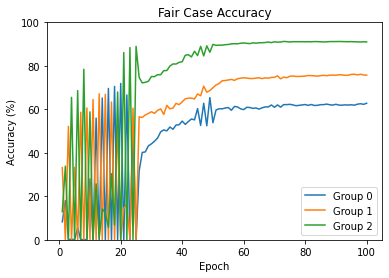

In [ ]:
make_plot(fair_accuracy, 100, "Fair Case Accuracy", "Accuracy (%)", False )

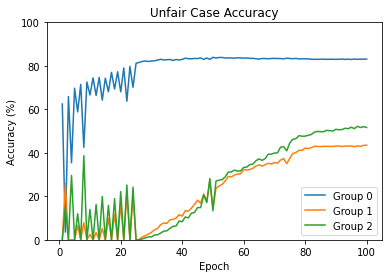

In [ ]:
make_plot(unfair_accuracy, 100, "Unfair Case Accuracy", "Accuracy (%)", False )

----
### **3. Quantization of Local Models for Reduced Communication Cost**
-----
Quantization refers to the process of reducing the number of bits used to represent a number. In the context of deep learning, the predominant numerical format used in research and deployment has been 32-bit floating-point ([IEEE 754 Format](https://en.wikipedia.org/wiki/Single-precision_floating-point_format)).
However, the desire for reduced model size and computation has led to research on using fewer bits to represent numbers in deep learning models.
This can impact several aspects of the pipeline, including computation, communication, and storage requirements.
For example, in the context of federated learning, quantizing a client model from full (32-bit) precision to 8-bit precision will reduce the model size by ~4×.
Furthermore, because the model size is reduced, the communication required for uploading a client model is also reduced by ~4× as well.

However, this quantization comes with trade-offs.
To see this, consider a full precision representation (32-bit floating point). This representation has a large dynamic range (from $-3.4\times 10^{38}$ to $+3.4\times10^{38}$) and high precision (about $7$ decimal digits).
As a result, a full precision number can be seen as continuous data.
In contrast, $n$-bit fixed-point representations are limited to $2^n$ discrete values.
$n$-bit quantization generally refers to projecting a full precision weight to one of these $2^n$ discrete values by finding its nearest neighbor.  

--------
<font color='red'>**PART 3.1:**</font> [5 points]

In this part, we will write a function to project full-precision numbers into $n$-bit fixed-point numbers.
For example, suppose we want to project full-precision numbers in the range of $[0, 1]$ into an 8-bit fixed point representation, $\frac{1}{2^8-1}\times(0, 1, 2, 3, \dots, 253, 254,255)$, where $\frac{1}{2^8-1}$ is the **scale factor** of the 8-bit fixed-point representation. 

<font color='red'>**Deliverables**</font>
1. In *Code Cell 3.1*, implement a function that converts full-precision numbers in the range $[0, 1]$ into $n$-bit fixed-point numbers.
If your implementation is correct, it should return *'Output of Quantization Matches!'*.

In [ ]:
## Code Cell 3.1

def quantizer(input, nbit):
    '''
    input: full precision tensor in the range [0, 1]
    return: quantized tensor
    '''
    # Part 3.1: Implement!
    # Hint: torch.round
    return torch.round(input * ((1<<nbit)-1)) / ((1<<nbit)-1)


# Test Code
test_data = torch.tensor([i/11 for i in range(11)])

# ground truth results of 4-bit quantization
ground_truth = torch.tensor([0.0000, 0.0667, 0.2000, 0.2667, 0.3333, 0.4667,
                             0.5333, 0.6667, 0.7333, 0.8000, 0.9333])

# output of your quantization function
quantizer_output = quantizer(test_data, 4)

if torch.allclose(quantizer_output, ground_truth, atol=1e-04):
    print('Output of Quantization Matches!')
else:
    print('Output of Quantization DOES NOT Match!')

Output of Quantization Matches!


**Quantize Weights of Neural Networks**

The quantizer in **PART 3.1** will quantize any full-precision number in the range of $[0, 1]$ into an $n$-bit fixed-point number.
However, a weight $w$ in a neural network is not necessarily in the range $[0, 1]$. 

To use the quantizer in **PART 3.1**, we will first use a scaling function to transform weights into the range of $[0 ,1]$:
$$\tilde{w} = \frac{w}{2 \cdot \max(|w|)} + \frac{1}{2}$$ 
where $2 \cdot \max(|w|)$ is the **adaptive scale**.

Then, we quantize the transformed weights:
$$\hat{w} = \text{quantizer}_{\text{n-bit}}(\tilde{w})$$
After quantization, a reverse scaling function can be applied on $\hat{w}$ to recover the original scale:

$$w_q = 2 \cdot \max(|w|) \cdot \left( \hat{w}-\frac{1}{2} \right)$$

Combining these three equations, the expression we will use to get the quantized weights $w_q$ is as follows:
$$w_q = 2 \cdot \max(|w|) \cdot \left[ \text{quantizer}_{\text{n-bit}} \left( \frac{w}{2\max(|w|)} + \frac{1}{2} \right) - \frac{1}{2} \right]$$

This equation is the **deterministic quantization function**. 

Following the method proposed by [DoReFa-Net](https://arxiv.org/abs/1606.06160), we enable *stochastic quantization* by adding extra noise $N(n) = \frac{\sigma}{2^n-1}$ to the transformed weights $\tilde{w}$, where $\sigma \sim \text{Uniform}(-0.5, 0.5)$ and $n$ is the number of bits.
Generally, including such extra noise will coax the model into exploring more of the loss surface, helping the model escape local minima and improve model generalizability.  

The final **stochastic quantization function** we will use to quantize layers of local models is:

$$w_q = 2 \cdot \max(|w|) \cdot \left[ \text{quantizer}_{\text{n-bit}} \left( \frac{w}{2 \cdot \max(|w|)} + \frac{1}{2} + N(n) \right) - \frac{1}{2} \right]$$


<font color='red'>**PART 3.2:**</font> [10 points]

<font color='red'>**Deliverables**</font>
1. In *Code Cell 3.2*, implement `dorefa_g(w, nbit, adaptive_scale=None)` using the **stochastic quantization function** shown above. Again, if your implementation is correct, it should return *'Output of Quantization Matches!'*.


In [ ]:
## Code Cell 3.2

def quantize_model(model, nbit):
    '''
    Used in Code Cell 3.3 to quantize the ConvNet model
    '''
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            m.weight.data, m.adaptive_scale = dorefa_g(m.weight, nbit)
            if m.bias is not None:
                m.bias.data,_ = dorefa_g(m.bias, nbit, m.adaptive_scale)

def dorefa_g(w, nbit, adaptive_scale=None):
    '''
    w: a floating-point weight tensor to quantize
    nbit: the number of bits in the quantized representation
    adaptive_scale: the maximum scale value. if None, it is set to be the
                    absolute maximum value in w.
    '''
    if adaptive_scale is None:
        adaptive_scale = 2 * torch.max(torch.abs(w)) # NOTE(janet): this used to be just torch.max(torch.abs(w)) -- I added the 2* to make it match the defn above

    # Part 3.2: Implement based on stochastic quantization function above
    N = (torch.rand_like(w)-0.5)/((1 << nbit) - 1)
    w_q = adaptive_scale*(quantizer(w/adaptive_scale + 0.5 + N, nbit) - 0.5)


    # remove placeholder "return w, adaptive_scale" line below 
    # after you implement
    return w_q, adaptive_scale


# Test Code
test_data = torch.tensor([i/11 for i in range(11)])

# ground truth results of 4-bit quantization
ground_truth = torch.tensor([-0.0606, 0.0606, 0.1818, 0.3030, 0.3030, 0.4242,
                             0.5455, 0.5455, 0.7879, 0.7879, 0.9091])

# output of your quantization function
torch.manual_seed(43)
quantizer_output, adaptive_scale = dorefa_g(test_data, 4)

if torch.allclose(quantizer_output, ground_truth, atol=1e-04):
    print('Output of Quantization Matches!')
else:
    print('Output of Quantization DOES NOT Match!')

Output of Quantization Matches!


**Reduce the Communication Overhead with Quantization**

We will now explore the performance impact of quantization on federated learning. We will use the IID setting from **PART 1**. You will use the same federated learning code, but will first quantize each local model with the `quantize_model` function you wrote above before uploading to the central server (*Line 27, Code Cell 3.3*).

<font color='red'>**PART 3.3:**</font> [10 points]

<font color='red'>**Deliverables**</font>
1. In *Code Cell 3.3*, run federated learning with the following two quantization settings (bit widths): `nbit=16` and `nbit=4`. Plot the accuracy of the global models over 100 rounds for the different bit widths: 32-bit (the full-precision baseline you ran previously), 16-bit, and 4-bit.  
2. Discuss the accuracy difference between the global models across the three different bit width settings: 32-bit, 16-bit, and 4-bit. (100 words maximum)

In [ ]:
## Code Cell 3.3

# Part 3.2: Train two settings with nbit=16 and nbit=4.
#           Compare against the floating-point performance
#           of the final FL model trained in Part 1.3.
nbit = 16

rounds = 100
local_epochs = 4
num_devices = 50
device_pct = 0.1
data_pct = 0.1
net = ConvNet().cuda()
criterion = nn.CrossEntropyLoss()

data_idxs = iid_sampler(trainset, num_devices, data_pct)
devices = [create_device(net, i, trainset, data_idxs[i])
           for i in range(num_devices)]

## IID Federated Learning
start_time = time.time()
for round_num in range(rounds):
    # Part 3.3: Implement!
    # Hint: you can use your federated learning code from PART 1
    round_devices = get_devices_for_round(devices, device_pct)
    print('Round: ', round_num)
    for device in round_devices:
      for local_epoch in range(local_epochs):
        train(local_epoch, device)

      quantize_model(device['net'], nbit)
    
    # Weight averaging
    w_avg = average_weights(round_devices)

    for device in devices:
        device['net'].load_state_dict(w_avg)
        device['optimizer'].zero_grad()
        device['optimizer'].step()
        device['scheduler'].step()

    # test accuracy after aggregation
    test(round_num, devices[0])

total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

In [ ]:
save_trackers(devices[0], "trackers_3_1_4bit.pth")

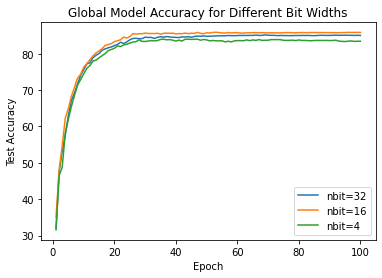

In [ ]:
trackers = {}

_,_,_,trackers['nbit=32'], time1 = torch.load("trackers_1_3.pth")
_,_,_, trackers['nbit=16'], time2 = torch.load("trackers_3_1_16bit.pth")
_,_,_, trackers['nbit=4'], time3 = torch.load("trackers_3_1_4bit.pth")

make_plot(trackers, 100, "Global Model Accuracy for Different Bit Widths", "Test Accuracy",False,True,False)

---

### **4. Gradient Inversion Attacks to Federated Learning**

In this part, you will explore the gradient inversion attacks which may break privacy in federated learning. In federated learning, each client receives the current global weights of the network and sends weights updates (gradients) based on local data. But how secure is sharing weights gradients? The [Deep Leakage](https://arxiv.org/pdf/1906.08935.pdf) paper shows it is possible to recover data given weights gradients. To perform the attack, Deep Leakage first randomly generates a pair of
"dummy" inputs and labels and then performs the usual forward and backwards computation. After deriving the dummy gradients from the dummy data, instead of optimizing model weights as in typical training, Deep Leakage optimizes the dummy inputs and labels to minimize the distance between dummy gradients and real gradients. You may refer to this paper for more details.

<font color='red'>**PART 4.1:**</font> [15 points]

In this part, we conduct a gradient inversion attack on a ConvNet model and implement several defense strategies. You will run experiments under 4 different settings:
1. Baseline: original Deep Leakage without any defenses (we have provided this code in *Code Cell 4.1*)
2. Noise: defend against the attack by injecting Guassian noise $\mathcal{N}(0, 10^{-3})$ to the weights gradients
3. Pruning: defend against the attack by pruning gradients: use unstructured magnitude pruning to set 20% of the gradient values to zero.
4. Quantization: defend against the attack by performing 4-bit quantization (`nbit=4`) on the gradients with the function you implemented in **PART 3.2**.

<font color='red'>**Deliverables**</font>

1. Implement the three defense strategies (i.e., noise injection, pruning, and quantization) `defense_method` in *Code Cell 4.1*.
2. Run the 4 experiments (i.e., Baseline, Noise, Pruning, and Quantization). For each experiment, you should report: (1) the final inversion result as measured by $\|\text{image}-\text{recovered_image}\|_2$ and (2) the optimization process of inversion using *Code Cell 4.2*.
3. Compare and discuss the effectiveness of the 3 different defense strategies. (100 words maximum)


In [ ]:
#Adapted from PA2:
   
def unstructured_pruning(dy_dx, prune_percent):
  result = []
  for weight_tensor in dy_dx:
      num_total = weight_tensor.numel()
      
      num_prune = round(num_total * prune_percent)
      # make a copy so we can destroy it 
      current_layer_weights = torch.clone(weight_tensor)
      # print(weight_tensor.shape)
      # flatten, get the indices of the min elts, and reshape back into the original
      # kind of a hack but works fine
      _, indices = torch.topk(current_layer_weights.flatten().abs(), num_prune,  largest=False, sorted=False)
      
      indices = (np.array(np.unravel_index(indices.cpu().numpy(), weight_tensor.shape)).T)
      # zero the min indieces 
      
      # This could be a single torch operation but this is fast enough
      # for pruning
      for i in indices:
        if(len(i) == 2): 
          weight_tensor[i[0],i[1]] = 0
        else:
          weight_tensor[i] = 0 
      # recompute and print this data since it's interesting
      result.append(weight_tensor)
  return result

Files already downloaded and verified
Running on cpu
GT label is 84. 
Onehot label is 84.


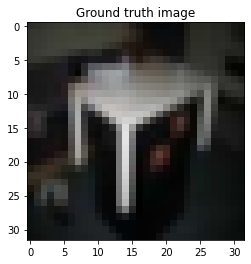

In [ ]:
## Code Cell 4.1 
dst = torchvision.datasets.CIFAR100("./data", download=True) #@Emin: I added the torchvision. part to this line. I should, right? Someone confirm pls i need constant validation
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
# if torch.cuda.is_available():
    # device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))


def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
    
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out
    
net = LeNet().to(device)
    
net.apply(weights_init)
criterion = cross_entropy_for_onehot

######### one client #########
img_index = 25
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())



In [ ]:
# compute original gradient 
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())


# share the gradients with the server
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

#EMIN CHANGE START

def defense_method(dy_dx, defense_strategy):

  if defense_strategy=='none':
    # no defense
    return dy_dx

  elif defense_strategy=='pruning':
    # pruning - PART 4.1
    return unstructured_pruning(dy_dx, 0.20)

  elif defense_strategy=='quantization':
    # quantization - PART 4.1
    for i in range(len(dy_dx)):
      dy_dx[i]=dorefa_g(dy_dx[i], 4)[0]#@Emin: someone better check this too pls. 
    return dy_dx
  
  elif defense_strategy=='noise':
    # noise injection - PART 4.1
    for i in range(len(dy_dx)):
      noise=(1e-3**(1/2))*torch.randn(dy_dx[i].size())
      dy_dx[i]= dy_dx[i]+noise
    return dy_dx
  
original_dy_dx = defense_method(original_dy_dx, 'none')
#EMIN CHANGE END


Dummy label is 46.
0 16.1877
10 0.2947
20 0.0458
30 0.0092
40 0.0024
50 0.0008
60 0.0003
70 0.0001
80 0.0000
90 0.0000
100 0.0000
110 0.0000
120 0.0000
130 0.0000
140 0.0000
150 0.0000
160 0.0000
170 0.0000
180 0.0000
190 0.0000
200 0.0000
210 0.0000
220 0.0000
230 0.0000
240 0.0000
250 0.0000
260 0.0000
270 0.0000
280 0.0000
290 0.0000


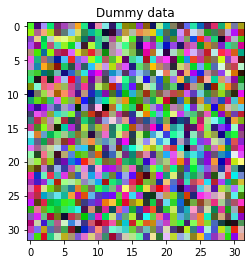

In [ ]:
######### Start attack ##########

# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
    history.append(tt(dummy_data[0].cpu()))

Dummy label is 84.


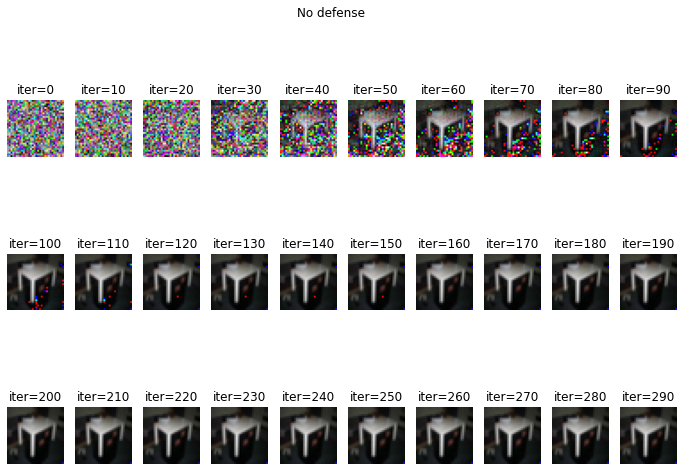

In [ ]:
## Code Cell 4.2 
plt.figure(figsize=(12, 8))
for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')
plt.suptitle('No defense') 

print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [ ]:
print("No defense final inversion error:")
torch.linalg.vector_norm(gt_data[0].cpu() - dummy_data[0].cpu()).detach()

No defense final inversion error:


tensor(0.1745)

Dummy label is 28.
0 123.5204
10 88.1819
20 86.3892
30 85.9053
40 85.6410
50 85.5019
60 85.4187
70 85.3554
80 85.3167
90 85.2862
100 85.2636
110 85.2431
120 85.2300
130 85.2183
140 85.2084
150 85.1997
160 85.1913
170 85.1856
180 85.1818
190 85.1781
200 85.1748
210 85.1724
220 85.1707
230 85.1688
240 85.1665
250 85.1656
260 85.1636
270 85.1623
280 85.1608
290 85.1599


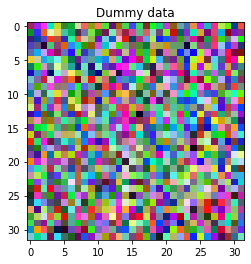

In [ ]:
## Code Cell 4.1 
net = LeNet().to(device)
    
net.apply(weights_init)
criterion = cross_entropy_for_onehot

######### one client #########
img_index = 25
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)


# compute original gradient 
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())

# share the gradients with the server
original_dy_dx = list((_.detach().clone() for _ in dy_dx))
  
original_dy_dx = defense_method(original_dy_dx, 'noise')
######### Start attack ##########

# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
    history.append(tt(dummy_data[0].cpu()))

Dummy label is 84.


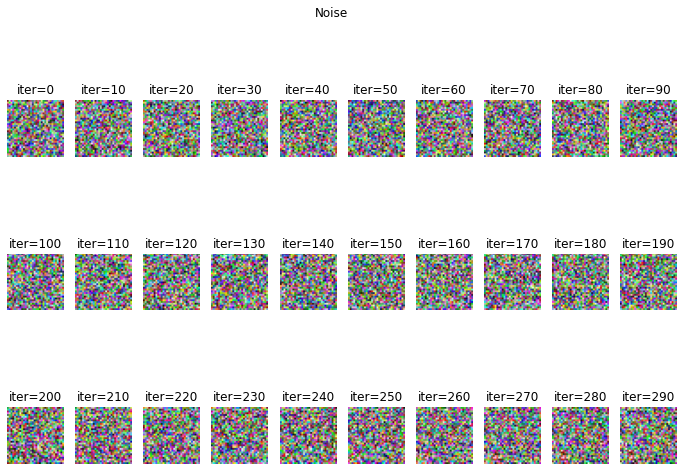

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')
plt.suptitle('Noise') 

print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [ ]:
print("Noise final inversion error:")
torch.linalg.vector_norm(gt_data[0].cpu() - dummy_data[0].cpu()).detach()

Noise final inversion error:


tensor(243.6848)

Dummy label is 45.
0 72.4707
10 40.7245
20 38.2452
30 37.0783
40 36.3343
50 35.6805
60 35.3060
70 35.1049
80 34.9668
90 34.8484
100 34.7547
110 34.6750
120 34.5982
130 34.5343
140 34.4886
150 34.4362
160 34.3785
170 34.3249
180 34.2716
190 34.2237
200 34.1774
210 34.1436
220 34.1111
230 34.0791
240 34.0527
250 34.0330
260 34.0168
270 34.0034
280 33.9912
290 33.9781


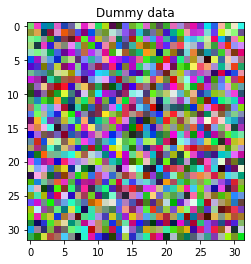

In [ ]:
## Code Cell 4.1 
net = LeNet().to(device)
    
net.apply(weights_init)
criterion = cross_entropy_for_onehot

######### one client #########
img_index = 25
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)


# compute original gradient 
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())

# share the gradients with the server
original_dy_dx = list((_.detach().clone() for _ in dy_dx))
  
original_dy_dx = defense_method(original_dy_dx, 'pruning')
######### Start attack ##########

# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
    history.append(tt(dummy_data[0].cpu()))

Dummy label is 84.


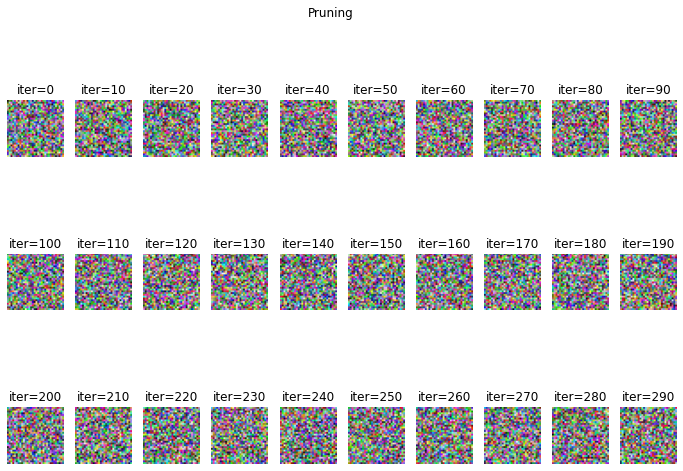

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')
plt.suptitle('Pruning') 

print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [ ]:
print("Pruning final inversion error:")
torch.linalg.vector_norm(gt_data[0].cpu() - dummy_data[0].cpu()).detach()

Pruning final inversion error:


tensor(451.3116)

Dummy label is 88.
0 400.0279
10 352.3625
20 346.9757
30 345.6434
40 344.8542
50 344.4751
60 344.2043
70 343.9935
80 343.8396
90 343.7441
100 343.6706
110 343.6130
120 343.5701
130 343.5375
140 343.5070
150 343.4775
160 343.4507
170 343.4245
180 343.3986
190 343.3824
200 343.3729
210 343.3633
220 343.3577
230 343.3512
240 343.3445
250 343.3271
260 343.3153
270 343.3092
280 343.3050
290 343.3012


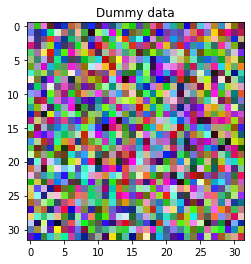

In [ ]:
## Code Cell 4.1 
net = LeNet().to(device)
    
net.apply(weights_init)
criterion = cross_entropy_for_onehot

######### one client #########
img_index = 25
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)


# compute original gradient 
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())

# share the gradients with the server
original_dy_dx = list((_.detach().clone() for _ in dy_dx))
  
original_dy_dx = defense_method(original_dy_dx, 'quantization')
######### Start attack ##########

# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
    history.append(tt(dummy_data[0].cpu()))

Dummy label is 84.


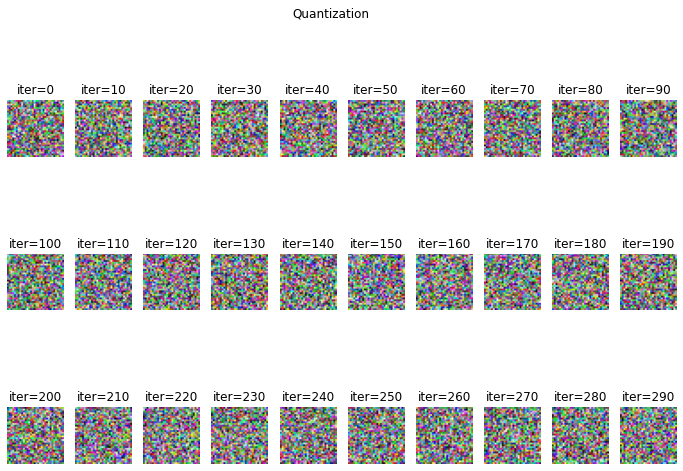

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')
plt.suptitle('Quantization') 

print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [ ]:
print("Quantization final inversion error:")
torch.linalg.vector_norm(gt_data[0].cpu() - dummy_data[0].cpu()).detach()

Quantization final inversion error:


tensor(248.4983)